<a href="https://colab.research.google.com/github/sepandms/SkinCare/blob/main/CNN_60x45.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install pickle5
file_link = "https://drive.google.com/u/0/uc?id=1oDoZz3baGVaX6pZwHfxi0W8SNymKcLzL"
#name = 'DataSource_60x45_blc_noDup.pkl'
#!wget -O {name} {file_link} -N
!wget --content-disposition {file_link}  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 3.2 MB/s 
--2022-06-07 10:24:02--  https://drive.google.com/u/0/uc?id=1oDoZz3baGVaX6pZwHfxi0W8SNymKcLzL
Resolving drive.google.com (drive.google.com)... 108.177.111.102, 108.177.111.113, 108.177.111.101, ...
Connecting to drive.google.com (drive.google.com)|108.177.111.102|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.google.com/uc?id=1oDoZz3baGVaX6pZwHfxi0W8SNymKcLzL [following]
--2022-06-07 10:24:02--  https://drive.google.com/uc?id=1oDoZz3baGVaX6pZwHfxi0W8SNymKcLzL
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-2g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hqll6j0jp9vhpqq9q3nophbq37ummh0m/1654597425000/09755144277486379277/*/1oDoZz3baGVaX6pZwHfxi0W8SNymKcLzL [following]
--2022-06

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
#import torchvision.transforms.Compose
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.data import SubsetRandomSampler
import time
import tqdm
import pickle5 as pickle
from statistics import mean
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split
device = 'cuda'
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')
#path = '/Users/sepehrbe/DataSources/Kaggle/SkinCare/Data/Pickle_Data/'
#p_models = '/Users/sepehrbe/DataSources/Kaggle/SkinCare/Models/Saved/'
#device = torch.device("cpu")
path = '/content/drive/MyDrive/DataSources/'

In [5]:
#file = 'test1.pkl' 
file = 'DataSource_60x45_blc_noDup.pkl' 

infile = open(file,'rb')
data = pickle.load(infile)

In [6]:
train_data = data[data.type=='train']
valid_data = data[data.type=='valid']
test_data = data[data.type=='test']

training_data = pd.concat([train_data,valid_data], axis=0)
print('Train size: ',train_data.shape[0] ,' Valid Size: ',valid_data.shape[0], ' Test size: ', test_data.shape[0])

Train size:  2375  Valid Size:  420  Test size:  311


# **Standardize Train and Validation data**

In [7]:
training_arrays = np.stack(training_data['img_array'].values)  
training_arrays_scaled = training_arrays / 255
Mean = training_arrays_scaled.mean(axis = (0,1,2)) 
STD = training_arrays_scaled.std(axis = (0,1,2))
print(f"Mean : {Mean}   STD: {STD}") 

Mean : [0.74757306 0.55395043 0.57981832]   STD: [0.13901983 0.1466928  0.16243817]


In [8]:
#Train data standardization
train_arrays_std = np.stack(train_data['img_array'].values) / 255
for i in range(0,train_arrays_std.shape[0]):
    train_arrays_std[i] = (train_arrays_std[i] - Mean) / STD
#Validation data standardization
valid_arrays_std = np.stack(valid_data['img_array'].values) / 255
for i in range(0,valid_arrays_std.shape[0]):
    valid_arrays_std[i] = (valid_arrays_std[i] - Mean) / STD
#Test data standardization
test_arrays_std = np.stack(test_data['img_array'].values) / 255
for i in range(0,test_arrays_std.shape[0]):
    test_arrays_std[i] = (test_arrays_std[i] - Mean) / STD

In [9]:
Mean_t = train_arrays_std.mean(axis = (0,1,2)) 
STD_t = train_arrays_std.std(axis = (0,1,2))
print(f"Mean : {Mean_t}   STD: {STD_t}") 

Mean : [-0.00228189  0.00041095 -0.00230894]   STD: [1.00738491 1.00246694 1.00100759]


In [27]:
train_arrays_std_T = torch.tensor(train_arrays_std, dtype= torch.float32).transpose(3,1)
train_labels = torch.tensor(train_data['label_id'].values.astype(np.long))

valid_arrays_std_T = torch.tensor(valid_arrays_std, dtype= torch.float32).transpose(3,1)
valid_labels = torch.tensor(valid_data['label_id'].values.astype(np.long))

test_arrays_std_T = torch.tensor(test_arrays_std, dtype= torch.float32).transpose(3,1)
test_labels = torch.tensor(test_data['label_id'].values.astype(np.long))

input_data = (train_arrays_std_T , valid_arrays_std_T, test_arrays_std_T , torch.cat((train_arrays_std_T,valid_arrays_std_T),0) )
labels = (train_labels,valid_labels,test_labels , torch.cat((train_labels,valid_labels),0))

# **Show some Images**

--------Original Image----------
i:  ISIC_0031498
Image:2346, target:mel


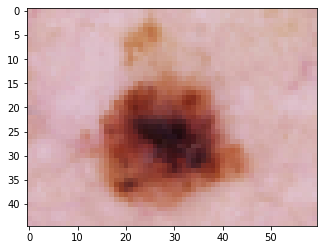

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---------Normilized Image---------


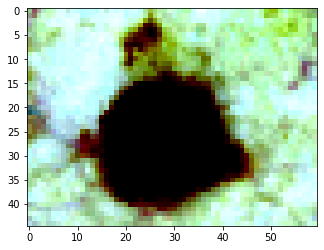

###################################
--------Original Image----------
i:  ISIC_0028079
Image:963, target:bcc


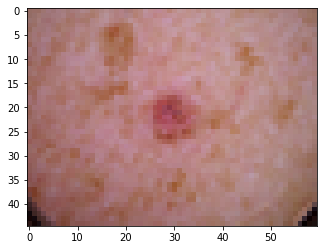

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---------Normilized Image---------


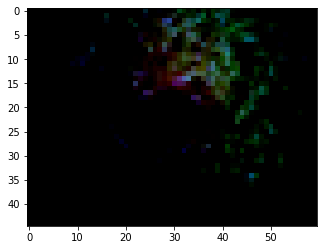

###################################
--------Original Image----------
i:  ISIC_0028308
Image:2271, target:bkl


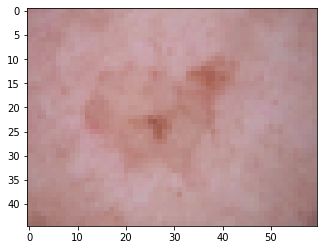

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---------Normilized Image---------


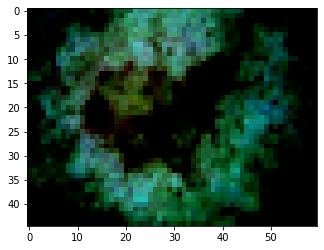

###################################


In [28]:
for i in np.random.choice(train_data.shape[0], 3, replace=False):
  print("--------Original Image----------")
  print('i: ', train_data['image_id'].iloc[i])
  image1 = torch.from_numpy(train_data['img_array'].iloc[i])
  print("Image:{}, target:{}".format(i, train_data['image_label'].iloc[i]))
  plt.imshow(image1, interpolation='nearest')
  plt.show()
  print("---------Normilized Image---------")
  image2 = train_arrays_std[i]
  plt.imshow(image2, interpolation='nearest')
  plt.show()
  print("###################################")

### **1.2 Nets**

In [12]:
class CNN_Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d( in_channels=3 , out_channels=32 , kernel_size=(3, 3))
        self.conv2 = nn.Conv2d( in_channels=32, out_channels=32 , kernel_size=(3, 3))
        self.pool1 = nn.MaxPool2d( kernel_size = (2,2), stride = None, padding = 0 )
        self.conv3 = nn.Conv2d( in_channels=32, out_channels=64 , kernel_size=(3, 3))
        self.conv4 = nn.Conv2d( in_channels=64, out_channels=64 , kernel_size=(3, 3))
        self.pool2 = nn.MaxPool2d( kernel_size = (2,2), stride = None, padding = 0 )
        self.fc1   = nn.Linear(in_features= 6144 , out_features = 512)
        self.fc2   = nn.Linear(in_features= 512, out_features = 7)
        self.Act   = nn.ReLU(inplace=True)
    def forward(self, x):
        out = self.Act(self.conv1(x))
        out = self.Act(self.conv2(out))
        out = self.Act(self.pool1(out))
        out = self.Act(self.conv3(out))
        out = self.Act(self.conv4(out))
        out = self.Act(self.pool2(out))
        out = torch.flatten(out, 1) 
        out = self.Act(self.fc1(out))
        out = self.Act(self.fc2(out))
        # out = nn.Softmax(out)
        return out

In [13]:
class CNN_Net2(nn.Module):
    def __init__(self):
        super(CNN_Net2, self).__init__()
        self.conv1 = nn.Conv2d( in_channels=3 , out_channels=32 , kernel_size=(3, 3))
        self.pool1 = nn.MaxPool2d( kernel_size = (2,2), stride = None, padding = 0 )
        self.conv3 = nn.Conv2d( in_channels=32, out_channels=64 , kernel_size=(3, 3))
        self.pool2 = nn.MaxPool2d( kernel_size = (2,2), stride = None, padding = 0 )
        self.fc1   = nn.Linear(in_features= 7488 , out_features = 512)
        self.fc2   = nn.Linear(in_features= 512, out_features = 7)
        self.Act   = nn.ReLU(inplace=True)
    def forward(self, x):
        out = self.Act(self.conv1(x))
        out = self.Act(self.pool1(out))
        out = self.Act(self.conv3(out))
        out = self.Act(self.pool2(out))
        out = torch.flatten(out, 1) 
        out = self.Act(self.fc1(out))
        out = self.Act(self.fc2(out))
        return out

In [14]:
class CNN_Net3(nn.Module):
    def __init__(self):
        super(CNN_Net3, self).__init__()
        self.conv1 = nn.Conv2d( in_channels=3 , out_channels=32 , kernel_size=(3, 3))
        self.pool1 = nn.MaxPool2d( kernel_size = (2,2), stride = None, padding = 0 )
        self.conv3 = nn.Conv2d( in_channels=32, out_channels=64 , kernel_size=(3, 3))
        self.pool2 = nn.MaxPool2d( kernel_size = (2,2), stride = None, padding = 0 )
        self.fc1   = nn.Linear(in_features= 7488 , out_features = 512)
        self.fc2   = nn.Linear(in_features= 512, out_features = 7)
        self.Act   = nn.LeakyReLU(inplace=True)
        self.dropout = nn.Dropout(0.25)
    def forward(self, x):
        out = self.Act(self.conv1(x))
        out = self.Act(self.pool1(out))
        out = self.Act(self.conv3(out))
        out = self.Act(self.pool2(out))
        out = self.dropout(out)
        out = torch.flatten(out, 1) 
        out = self.Act(self.fc1(out))
        out = self.Act(self.fc2(out))
        return out

# **Test Nets**

In [15]:
model_test = CNN_Net2()
X_ = input_data[0][0:5]
out = model_test(X_)
out.shape

torch.Size([5, 7])

# **Confusion-Matrix & Accuracy**

In [16]:
def confusion_matrix(Y_pred,Y):
    CM = sk.metrics.confusion_matrix(Y_pred,Y)
    Total_sum = sum(sum(CM))
    Diagonal_sum = np.trace(CM) 
    accuracy1 = Diagonal_sum / Total_sum
    frequencies = list(pd.DataFrame(Y).value_counts())
    weights = list(np.divide(frequencies, Total_sum))
    sensitivity = []
    specificity = []
    for i in range(0,7):
        sensitivity_ = CM[i,i].sum() / (CM[i].sum())
        sensitivity.append(sensitivity_)
        specificity_ = (Diagonal_sum - CM[i,i]) / (  (Diagonal_sum - CM[i,i]) + (CM.T[i].sum()-CM[i,i]))
        specificity.append(specificity_)
        
    print('Nr. of Data : \n', Total_sum)
    print('Accuracy of The Model : \n', accuracy1)
    # print('Confusion Matrix : \n', CM)
    print('Weighted Avg. of sensitivity : \n', np.average(np.nan_to_num(sensitivity), weights=weights))
    print('Weighted Avg. of specificity : \n', np.average(np.nan_to_num(specificity), weights=weights))
    sk.metrics.ConfusionMatrixDisplay(CM).plot()
    print('------- Precision recal %--------')
    print(sk.metrics.classification_report(Y,Y_pred))
    print('------- confusion matrix--------')

### **1.3 Training**

In [17]:
# Training
class Model_Training:

    def __init__(self, Net, LR, batch_size , Momentum, epochs, weight_decay, loss_func, opt_func, X_train, Y_train, X_valid, Y_valid):    
        
        self.model = Net().to(device)
        if opt_func is torch.optim.Adam:
            self.opt = opt_func(self.model.parameters(), lr=LR, weight_decay=weight_decay)
        else:
            self.opt = opt_func(self.model.parameters(), lr=LR,momentum=Momentum, weight_decay=weight_decay)

        self.loss_func = loss_func()
        self.epochs = epochs
        self.X_train = X_train.to(device)
        self.Y_train = Y_train.to(device)
        self.X_valid = X_valid.to(device)
        self.Y_valid = Y_valid.to(device)
        self.batch_size = batch_size
        self.Epochs_Train_loss = []
        self.Epochs_Train_Acc = []
        self.Epochs_Val_loss = []
        self.Epochs_Val_Acc = []

    def train(self):
        
        model = self.model
        loss_fn = self.loss_func
        opt = self.opt 
        batch_size = self.batch_size
        nr_of_steps_train =  self.X_train.shape[0]//self.batch_size 
        nr_of_steps_valid =  self.X_valid.shape[0]//self.batch_size 

        for epoch in range(1, self.epochs+1 ):
            start_time=time.time()
            steps_train_loss = []
            steps_train_Acc = []
            steps_val_loss = []
            steps_val_Acc = []

            for i in range(0, nr_of_steps_train ):#train_arrays_std.shape[0]):
                X = self.X_train[i* batch_size:(i+1) * batch_size]
                Y = self.Y_train[i * batch_size:(i+1) * batch_size]
                opt.zero_grad()
                model.train()
                y_pred = model.forward(X)
                loss = loss_fn(y_pred, Y)
                loss.backward()
                opt.step()
                y_pred_labels = y_pred.argmax(axis=1)
                nr_of_corrects = (y_pred_labels == Y).sum().item()
                step_acc = nr_of_corrects / batch_size
                steps_train_Acc.append(step_acc)
                steps_train_loss.append(loss.item())

                # if (i+1) % 200 == 0:    # print every 2000 mini-batches
                #     print('[Epoch: {}, Nr. Batch: {}]  , Train-Steps-loss: {:.1f} , running_acc: {:.1%}'.format(epoch , i+1 , train_steps_loss , batch_nr_correct / train_nr_total))
                #     self.train_steps_acc = []
                #     train_steps_loss = 0

              #validation loss calculation
            for j in range(0,nr_of_steps_valid):

                val_X = self.X_valid[j*batch_size:(j+1)*batch_size]
                val_Y = self.Y_valid[j*batch_size:(j+1)*batch_size]
                model.eval()
                # val_inputs = val_inputs.to(device)
                # val_labels = val_labels.to(device)
                val_outputs = model(val_X)
                val_loss = loss_fn(val_outputs, val_Y)
                val_epoch_loss = val_loss.item()
                val_outputs_lbs= val_outputs.argmax(axis=1)
                val_nr_correct = (val_outputs_lbs == val_Y).sum().item()
                step_acc = val_nr_correct / batch_size
                steps_val_Acc.append(step_acc)
                steps_val_loss.append(val_epoch_loss)
            
            # Epoch Performance Metrics
            train_epoch_loss = mean(steps_train_loss)
            train_epoch_Acc = mean(steps_train_Acc)
            self.Epochs_Train_loss.append(train_epoch_loss)
            self.Epochs_Train_Acc.append(train_epoch_Acc)   
            val_epoch_loss = mean(steps_val_loss)
            val_epoch_Acc = mean(steps_val_Acc)
            self.Epochs_Val_loss.append(val_epoch_loss)
            self.Epochs_Val_Acc.append(val_epoch_Acc)
            End_time = time.time()   
            print('[Epoch: {}]  , Train_loss: {:.1f} , Train_Acc: {:.1%}, Val_loss: {:.1f} , Val_Acc: {:.1%} , run time: {}'
            .format(epoch , train_epoch_loss , train_epoch_Acc , val_epoch_loss , val_epoch_Acc, np.round(End_time - start_time, 2)))
            
        print('Finished Training')

# **Assign Training data**

In [18]:
X_train = input_data[0]
Y_train = labels[0]
X_valid = input_data[1]
Y_valid = labels[1]
X_test = input_data[2]
Y_test = labels[2]

# **Model by Grid**

In [ ]:
Net = [CNN_Net2,CNN_Net3]
LR = [0.001,0.0012,0.0015,0.0018,0.01]
batch_size = [64,30,50]
Momentum = [0.65,0.72,0.8]
epochs = [50]
weight_decay = [0,0.0001,0.000001,0.0000002]
loss_func  =  [nn.CrossEntropyLoss]
opt_func = [torch.optim.SGD,torch.optim.Adam]

grid = {
    'Net' : Net
    ,'LR' : LR
    ,'batch_size' : batch_size
    ,'Momentum' : Momentum
    ,'epochs' : epochs
    ,'weight_decay' :weight_decay
    ,'loss_func'  :loss_func
    ,'opt_func' : opt_func
}
params = sk.model_selection.ParameterGrid(grid)

In [ ]:
Hyper_Details = pd.DataFrame(columns=['hyper_param','train_accuracy','valid_accuracy','test_accuracy','train_fscore','valid_fscore','test_fscore','train_precision','valid_precision','test_precision'
                                    ,'train_recall','valid_recall','test_recall'])                                 
for p in params:
    Model_ = Model_Training2(**p, X_train = X_train , Y_train = Y_train, X_valid = X_valid , Y_valid= Y_valid)
    torch.manual_seed(0)
    Model_.train()
    
    model_ = Model_.model.eval()

    # Train
    Y_pred = model_(X_train.to(device)).argmax(axis=1)
    Y = Y_train
    train_accuracy = sk.metrics.accuracy_score(Y_pred.to('cpu'),Y.to('cpu') )

    train_precision, train_recall, train_fscore, m = sk.metrics.precision_recall_fscore_support(Y_pred.to('cpu'),Y.to('cpu'), average = 'weighted')

    # Valid
    Y_pred = model_(X_valid.to(device)).argmax(axis=1)
    Y = Y_valid
    valid_accuracy = sk.metrics.accuracy_score(Y_pred.to('cpu'),Y.to('cpu') )
    valid_precision, valid_recall, valid_fscore, m = sk.metrics.precision_recall_fscore_support(Y_pred.to('cpu'),Y.to('cpu'), average = 'weighted')

    # Test
    Y_pred = model_(X_test.to(device)).argmax(axis=1)
    Y = Y_test
    test_accuracy = sk.metrics.accuracy_score(Y_pred.to('cpu'),Y.to('cpu') )
    test_precision, test_recall, test_fscore, m = sk.metrics.precision_recall_fscore_support(Y_pred.to('cpu'),Y.to('cpu'), average = 'weighted')


    new_row = pd.Series({'hyper_param':p,'train_accuracy':train_accuracy,'valid_accuracy':valid_accuracy,'test_accuracy':test_accuracy,'train_fscore':train_fscore,'valid_fscore':valid_fscore,'test_fscore':test_fscore
    ,'train_precision':train_precision,'valid_precision':valid_precision,'test_precision':test_precision,'train_recall':train_recall,'valid_recall':valid_recall,'test_recall':test_recall}, name='')
    Hyper_Details = Hyper_Details.append(new_row)

best_one = np.argmax(Hyper_Details.test_fscore)
best_param = Hyper_Details.iloc[best_one]['hyper_param']

CNN_Details = Hyper_Details
CNN_Details.to_csv('SkinCare_60x45_param_Details.csv')
Model_CV = Model_Training2(**best_param, X_train = X_train, Y_train = Y_train, X_valid = X_valid, Y_valid= Y_valid)
torch.manual_seed(0)
Model_CV.train()

In [ ]:
best_param

{'LR': 0.0015,
 'Momentum': 0.8,
 'Net': __main__.CNN_Net3,
 'batch_size': 30,
 'epochs': 50,
 'loss_func': torch.nn.modules.loss.CrossEntropyLoss,
 'opt_func': torch.optim.sgd.SGD,
 'weight_decay': 2e-07}

In [ ]:
model_ = Model_CV.model.eval()
X = input_data[2].to(device)
Y = labels[2].to(device)
Y_pred = model_(X).argmax(dim=1)
confusion_matrix(Y_pred.to('cpu'),Y.to('cpu'))

NameError: ignored

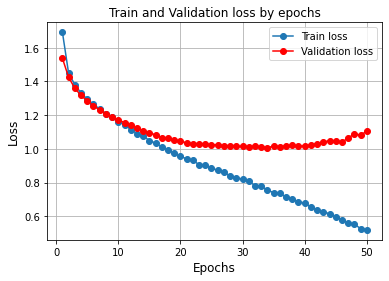

In [ ]:
model_ = Model_CV
epochs_X = [i for i in range(1, model_.epochs+1)]
epochs_X
plt.subplots(figsize=(6,4))

plt.plot(epochs_X , model_.Epochs_Train_loss, 'o-', label='Train loss')
plt.plot(epochs_X , model_.Epochs_Val_loss,'ro-', label='Validation loss')
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)
plt.grid()
plt.legend()
plt.title('Train and Validation loss by epochs')
plt.show()

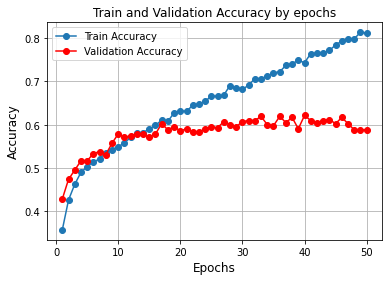

In [ ]:
model_ = Model_CV
epochs_X = [i for i in range(1, model_.epochs+1)]
epochs_X
plt.subplots(figsize=(6,4))

plt.plot(epochs_X , model_.Epochs_Train_Acc, 'o-', label='Train Accuracy')
plt.plot(epochs_X , model_.Epochs_Val_Acc,'ro-', label='Validation Accuracy')
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Accuracy", fontsize = 12)
plt.grid()
plt.legend()
plt.title('Train and Validation Accuracy by epochs')
plt.show()

# **Model 1**

In [24]:
param1 = {'LR': 0.0015,
 'Momentum': 0.8,
 'Net': CNN_Net3,
 'batch_size': 30,
 'epochs': 50,
 'loss_func': torch.nn.modules.loss.CrossEntropyLoss,
 'opt_func': torch.optim.SGD,
 'weight_decay': 2e-07}

In [20]:
Model_1 = Model_Training(**param1, X_train = X_train , Y_train = Y_train, X_valid = X_valid , Y_valid= Y_valid)
torch.manual_seed(0)
Model_1.train()

[Epoch: 1]  , Train_loss: 1.6 , Train_Acc: 34.6%, Val_loss: 1.5 , Val_Acc: 42.6% , run time: 1.04
[Epoch: 2]  , Train_loss: 1.4 , Train_Acc: 44.8%, Val_loss: 1.4 , Val_Acc: 47.1% , run time: 0.34
[Epoch: 3]  , Train_loss: 1.4 , Train_Acc: 47.6%, Val_loss: 1.3 , Val_Acc: 48.8% , run time: 0.35
[Epoch: 4]  , Train_loss: 1.3 , Train_Acc: 48.8%, Val_loss: 1.3 , Val_Acc: 49.3% , run time: 0.33
[Epoch: 5]  , Train_loss: 1.3 , Train_Acc: 50.8%, Val_loss: 1.3 , Val_Acc: 49.8% , run time: 0.32
[Epoch: 6]  , Train_loss: 1.3 , Train_Acc: 51.5%, Val_loss: 1.3 , Val_Acc: 51.7% , run time: 0.31
[Epoch: 7]  , Train_loss: 1.2 , Train_Acc: 53.0%, Val_loss: 1.2 , Val_Acc: 52.9% , run time: 0.3
[Epoch: 8]  , Train_loss: 1.2 , Train_Acc: 53.8%, Val_loss: 1.2 , Val_Acc: 53.8% , run time: 0.3
[Epoch: 9]  , Train_loss: 1.2 , Train_Acc: 54.7%, Val_loss: 1.2 , Val_Acc: 54.3% , run time: 0.31
[Epoch: 10]  , Train_loss: 1.2 , Train_Acc: 54.6%, Val_loss: 1.2 , Val_Acc: 53.6% , run time: 0.31
[Epoch: 11]  , Train_

Nr. of Data : 
 311
Accuracy of The Model : 
 0.6109324758842444
Weighted Avg. of sensitivity : 
 0.5421318200738332
Weighted Avg. of specificity : 
 0.9092806174415511
------- Precision recal %--------
              precision    recall  f1-score   support

           0       0.53      0.44      0.48        18
           1       0.66      0.61      0.63        31
           2       0.66      0.60      0.63        73
           3       0.00      0.00      0.00         8
           4       0.46      0.42      0.44        67
           5       0.65      0.80      0.71        99
           6       0.75      0.80      0.77        15

    accuracy                           0.61       311
   macro avg       0.53      0.53      0.52       311
weighted avg       0.59      0.61      0.60       311

------- confusion matrix--------


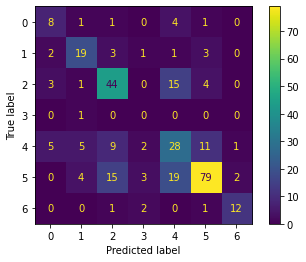

In [21]:
model_ = Model_1.model.eval()
X = input_data[2].to(device)
Y = labels[2].to(device)
Y_pred = model_(X).argmax(dim=1)
confusion_matrix(Y_pred.to('cpu'),Y.to('cpu'))

# **K-Fold Cross Validation**

In [29]:
K_Folds = sk.model_selection.KFold(n_splits=6, shuffle=True)

training_data = input_data[3]
training_label = labels[3]

# CV_Details_ = pd.DataFrame(columns=['test_fscore','test_precision','test_recall'])

CV_Details = pd.DataFrame(columns=['train_index','valid_index','train_accuracy','valid_accuracy','test_accuracy','train_fscore','valid_fscore','test_fscore','train_precision','valid_precision','test_precision'
                                    ,'train_recall','valid_recall','test_recall'])
for i in range(0,1):
    
    for fold, (train_index, valid_index) in tqdm.tqdm(enumerate(K_Folds.split(training_data)) , ncols = 100, desc ="Cross Validation - Level", total=K_Folds.n_splits ):

        X_train = training_data[train_index]
        Y_train = training_label[train_index]

        X_valid = training_data[valid_index]
        Y_valid = training_label[valid_index]

        Model_ = Model_Training(**param1, X_train = X_train, Y_train = Y_train, X_valid = X_valid, Y_valid= Y_valid)
        torch.manual_seed(0)
        Model_.train()

        model_ = Model_.model.eval()
            
        # Train
        Y_pred = model_(X_train.to(device)).argmax(axis=1)
        Y = Y_train
        train_accuracy = sk.metrics.accuracy_score(Y_pred.to('cpu'),Y.to('cpu') )
        train_precision, train_recall, train_fscore, m = sk.metrics.precision_recall_fscore_support(Y_pred.to('cpu'),Y.to('cpu') , average = 'weighted')

        # Valid
        Y_pred = model_(X_valid.to(device)).argmax(axis=1)
        Y = Y_valid
        valid_accuracy = sk.metrics.accuracy_score(Y_pred.to('cpu'),Y.to('cpu') )
        valid_precision, valid_recall, valid_fscore, m = sk.metrics.precision_recall_fscore_support(Y_pred.to('cpu'),Y.to('cpu') , average = 'weighted')

        # Test
        Y_pred = model_(X_test.to(device)).argmax(axis=1)
        Y = Y_test
        test_accuracy = sk.metrics.accuracy_score(Y_pred.to('cpu'),Y.to('cpu') )
        test_precision, test_recall, test_fscore, m = sk.metrics.precision_recall_fscore_support(Y_pred.to('cpu'),Y.to('cpu') , average = 'weighted')


        new_row = pd.Series({'train_index':train_index,'valid_index':valid_index,'train_accuracy':train_accuracy,'valid_accuracy':valid_accuracy,'test_accuracy':test_accuracy,'train_fscore':train_fscore,'valid_fscore':valid_fscore,'test_fscore':test_fscore
        ,'train_precision':train_precision,'valid_precision':valid_precision,'test_precision':test_precision,'train_recall':train_recall,'valid_recall':valid_recall,'test_recall':test_recall}, name='')
        CV_Details = CV_Details.append(new_row)

CNN_CV_Details = CV_Details

Cross Validation - Level:   0%|                                               | 0/6 [00:00<?, ?it/s]

[Epoch: 1]  , Train_loss: 1.7 , Train_Acc: 35.7%, Val_loss: 1.5 , Val_Acc: 40.2% , run time: 0.35
[Epoch: 2]  , Train_loss: 1.5 , Train_Acc: 42.9%, Val_loss: 1.5 , Val_Acc: 43.1% , run time: 0.3
[Epoch: 3]  , Train_loss: 1.4 , Train_Acc: 45.0%, Val_loss: 1.4 , Val_Acc: 48.0% , run time: 0.3
[Epoch: 4]  , Train_loss: 1.3 , Train_Acc: 48.9%, Val_loss: 1.3 , Val_Acc: 50.4% , run time: 0.3
[Epoch: 5]  , Train_loss: 1.3 , Train_Acc: 51.0%, Val_loss: 1.3 , Val_Acc: 51.3% , run time: 0.31
[Epoch: 6]  , Train_loss: 1.3 , Train_Acc: 51.5%, Val_loss: 1.3 , Val_Acc: 52.7% , run time: 0.29
[Epoch: 7]  , Train_loss: 1.2 , Train_Acc: 53.6%, Val_loss: 1.3 , Val_Acc: 53.1% , run time: 0.3
[Epoch: 8]  , Train_loss: 1.2 , Train_Acc: 54.0%, Val_loss: 1.2 , Val_Acc: 52.7% , run time: 0.3
[Epoch: 9]  , Train_loss: 1.2 , Train_Acc: 54.9%, Val_loss: 1.2 , Val_Acc: 54.9% , run time: 0.3
[Epoch: 10]  , Train_loss: 1.2 , Train_Acc: 56.0%, Val_loss: 1.2 , Val_Acc: 54.7% , run time: 0.3
[Epoch: 11]  , Train_loss:

Cross Validation - Level:  17%|██████▌                                | 1/6 [00:15<01:15, 15.17s/it]

[Epoch: 50]  , Train_loss: 0.5 , Train_Acc: 82.0%, Val_loss: 1.2 , Val_Acc: 56.9% , run time: 0.29
Finished Training
[Epoch: 1]  , Train_loss: 1.7 , Train_Acc: 35.5%, Val_loss: 1.5 , Val_Acc: 40.9% , run time: 0.3
[Epoch: 2]  , Train_loss: 1.5 , Train_Acc: 42.4%, Val_loss: 1.4 , Val_Acc: 42.7% , run time: 0.3
[Epoch: 3]  , Train_loss: 1.4 , Train_Acc: 46.8%, Val_loss: 1.3 , Val_Acc: 45.3% , run time: 0.29
[Epoch: 4]  , Train_loss: 1.3 , Train_Acc: 49.0%, Val_loss: 1.3 , Val_Acc: 45.8% , run time: 0.31
[Epoch: 5]  , Train_loss: 1.3 , Train_Acc: 50.3%, Val_loss: 1.3 , Val_Acc: 47.8% , run time: 0.31
[Epoch: 6]  , Train_loss: 1.3 , Train_Acc: 51.8%, Val_loss: 1.2 , Val_Acc: 50.2% , run time: 0.3
[Epoch: 7]  , Train_loss: 1.2 , Train_Acc: 53.0%, Val_loss: 1.2 , Val_Acc: 51.6% , run time: 0.29
[Epoch: 8]  , Train_loss: 1.2 , Train_Acc: 54.1%, Val_loss: 1.2 , Val_Acc: 53.6% , run time: 0.3
[Epoch: 9]  , Train_loss: 1.2 , Train_Acc: 55.0%, Val_loss: 1.2 , Val_Acc: 53.6% , run time: 0.3
[Epoch

Cross Validation - Level:  33%|█████████████                          | 2/6 [00:30<01:00, 15.17s/it]

[Epoch: 50]  , Train_loss: 0.5 , Train_Acc: 81.5%, Val_loss: 1.2 , Val_Acc: 59.3% , run time: 0.3
Finished Training
[Epoch: 1]  , Train_loss: 1.7 , Train_Acc: 37.0%, Val_loss: 1.6 , Val_Acc: 35.3% , run time: 0.29
[Epoch: 2]  , Train_loss: 1.4 , Train_Acc: 43.2%, Val_loss: 1.5 , Val_Acc: 39.3% , run time: 0.3
[Epoch: 3]  , Train_loss: 1.4 , Train_Acc: 46.9%, Val_loss: 1.5 , Val_Acc: 44.0% , run time: 0.3
[Epoch: 4]  , Train_loss: 1.3 , Train_Acc: 48.9%, Val_loss: 1.4 , Val_Acc: 46.4% , run time: 0.3
[Epoch: 5]  , Train_loss: 1.3 , Train_Acc: 51.3%, Val_loss: 1.4 , Val_Acc: 47.8% , run time: 0.3
[Epoch: 6]  , Train_loss: 1.2 , Train_Acc: 52.0%, Val_loss: 1.3 , Val_Acc: 48.4% , run time: 0.31
[Epoch: 7]  , Train_loss: 1.2 , Train_Acc: 53.1%, Val_loss: 1.3 , Val_Acc: 50.9% , run time: 0.31
[Epoch: 8]  , Train_loss: 1.2 , Train_Acc: 54.1%, Val_loss: 1.3 , Val_Acc: 52.7% , run time: 0.3
[Epoch: 9]  , Train_loss: 1.2 , Train_Acc: 55.5%, Val_loss: 1.3 , Val_Acc: 52.2% , run time: 0.3
[Epoch: 

Cross Validation - Level:  50%|███████████████████▌                   | 3/6 [00:45<00:45, 15.18s/it]

[Epoch: 50]  , Train_loss: 0.5 , Train_Acc: 82.9%, Val_loss: 1.4 , Val_Acc: 57.3% , run time: 0.3
Finished Training
[Epoch: 1]  , Train_loss: 1.7 , Train_Acc: 35.7%, Val_loss: 1.5 , Val_Acc: 44.4% , run time: 0.3
[Epoch: 2]  , Train_loss: 1.5 , Train_Acc: 42.4%, Val_loss: 1.4 , Val_Acc: 47.3% , run time: 0.3
[Epoch: 3]  , Train_loss: 1.4 , Train_Acc: 45.6%, Val_loss: 1.3 , Val_Acc: 54.0% , run time: 0.3
[Epoch: 4]  , Train_loss: 1.3 , Train_Acc: 47.6%, Val_loss: 1.3 , Val_Acc: 54.9% , run time: 0.3
[Epoch: 5]  , Train_loss: 1.3 , Train_Acc: 49.5%, Val_loss: 1.2 , Val_Acc: 55.6% , run time: 0.3
[Epoch: 6]  , Train_loss: 1.3 , Train_Acc: 51.8%, Val_loss: 1.2 , Val_Acc: 56.0% , run time: 0.3
[Epoch: 7]  , Train_loss: 1.2 , Train_Acc: 51.6%, Val_loss: 1.2 , Val_Acc: 57.1% , run time: 0.3
[Epoch: 8]  , Train_loss: 1.2 , Train_Acc: 52.9%, Val_loss: 1.2 , Val_Acc: 58.7% , run time: 0.3
[Epoch: 9]  , Train_loss: 1.2 , Train_Acc: 53.5%, Val_loss: 1.2 , Val_Acc: 59.3% , run time: 0.31
[Epoch: 10

Cross Validation - Level:  67%|██████████████████████████             | 4/6 [01:01<00:31, 15.50s/it]

[Epoch: 50]  , Train_loss: 0.5 , Train_Acc: 81.1%, Val_loss: 1.1 , Val_Acc: 63.3% , run time: 0.3
Finished Training
[Epoch: 1]  , Train_loss: 1.7 , Train_Acc: 36.0%, Val_loss: 1.5 , Val_Acc: 42.7% , run time: 0.3
[Epoch: 2]  , Train_loss: 1.5 , Train_Acc: 42.6%, Val_loss: 1.4 , Val_Acc: 46.2% , run time: 0.3
[Epoch: 3]  , Train_loss: 1.4 , Train_Acc: 45.8%, Val_loss: 1.3 , Val_Acc: 51.1% , run time: 0.3
[Epoch: 4]  , Train_loss: 1.3 , Train_Acc: 49.2%, Val_loss: 1.3 , Val_Acc: 51.3% , run time: 0.3
[Epoch: 5]  , Train_loss: 1.3 , Train_Acc: 49.9%, Val_loss: 1.3 , Val_Acc: 52.4% , run time: 0.31
[Epoch: 6]  , Train_loss: 1.3 , Train_Acc: 52.5%, Val_loss: 1.2 , Val_Acc: 53.1% , run time: 0.31
[Epoch: 7]  , Train_loss: 1.2 , Train_Acc: 53.5%, Val_loss: 1.2 , Val_Acc: 53.6% , run time: 0.3
[Epoch: 8]  , Train_loss: 1.2 , Train_Acc: 55.1%, Val_loss: 1.2 , Val_Acc: 55.1% , run time: 0.3
[Epoch: 9]  , Train_loss: 1.2 , Train_Acc: 55.4%, Val_loss: 1.2 , Val_Acc: 55.6% , run time: 0.31
[Epoch: 

Cross Validation - Level:  83%|████████████████████████████████▌      | 5/6 [01:16<00:15, 15.42s/it]

[Epoch: 50]  , Train_loss: 0.5 , Train_Acc: 81.5%, Val_loss: 1.2 , Val_Acc: 59.8% , run time: 0.3
Finished Training
[Epoch: 1]  , Train_loss: 1.7 , Train_Acc: 35.8%, Val_loss: 1.5 , Val_Acc: 41.6% , run time: 0.3
[Epoch: 2]  , Train_loss: 1.5 , Train_Acc: 44.4%, Val_loss: 1.5 , Val_Acc: 41.6% , run time: 0.31
[Epoch: 3]  , Train_loss: 1.4 , Train_Acc: 46.8%, Val_loss: 1.4 , Val_Acc: 45.6% , run time: 0.3
[Epoch: 4]  , Train_loss: 1.3 , Train_Acc: 49.7%, Val_loss: 1.4 , Val_Acc: 45.8% , run time: 0.3
[Epoch: 5]  , Train_loss: 1.3 , Train_Acc: 51.3%, Val_loss: 1.3 , Val_Acc: 47.6% , run time: 0.3
[Epoch: 6]  , Train_loss: 1.3 , Train_Acc: 53.2%, Val_loss: 1.3 , Val_Acc: 46.9% , run time: 0.3
[Epoch: 7]  , Train_loss: 1.2 , Train_Acc: 53.7%, Val_loss: 1.3 , Val_Acc: 47.1% , run time: 0.3
[Epoch: 8]  , Train_loss: 1.2 , Train_Acc: 54.6%, Val_loss: 1.3 , Val_Acc: 48.4% , run time: 0.29
[Epoch: 9]  , Train_loss: 1.2 , Train_Acc: 55.1%, Val_loss: 1.2 , Val_Acc: 50.2% , run time: 0.3
[Epoch: 1

Cross Validation - Level: 100%|███████████████████████████████████████| 6/6 [01:32<00:00, 15.33s/it]

[Epoch: 50]  , Train_loss: 0.5 , Train_Acc: 81.4%, Val_loss: 1.3 , Val_Acc: 58.0% , run time: 0.3
Finished Training


In [1]:
CNN_CV_Details

NameError: ignored

In [ ]:
train_index = CNN_CV_Details['train_index'][0]
valid_index = CNN_CV_Details['valid_index'][0]

X_train = input_data[3][train_index]
Y_train = labels[3][train_index]
X_valid = input_data[3][valid_index]
Y_valid = labels[3][valid_index]


In [ ]:
Model_CV = Model_Training2(**grid, X_train = X_train, Y_train = Y_train, X_valid = X_valid, Y_valid= Y_valid)
torch.manual_seed(0)
Model_CV.train()

# **Save the model**

In [ ]:
pickle.dump(Model_2, open(p_models + 'CNN_60x45_Duplicated', 'wb'))

In [ ]:
dill.dump([CNN_Net1,CNN_Net2,CNN_Net3, Model_Training], open(p_models + 'CNNs_Network_Training', "wb"))